In [1]:
# Notebook settings
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [2]:
# Default
import os
import urllib.request
import sys
import pandas as pd
import numpy as np


# import deeplc packages
from deeplc import DeepLC
from deeplcretrainer import deeplcretrainer
import tensorflow as tf
from tensorflow.python.eager import context

In [3]:
# Global settings

seed = 42
working_dir = '/cmnfs/home/z.xiao/miniconda3/envs/dlomix/lib'

# add custom modules
module_path = '/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan'
if module_path not in sys.path:
    sys.path.append(module_path)

os.chdir(working_dir)
tf.random.set_seed(seed)
tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Prepare input data
Input data from maxquant evidence.txt, column 'MS/MS scan number' --> 'Scan number'

In [4]:
import importlib
from prediction.RT import format_MQ_as_DeepLCinput, match_pred_to_input

In [27]:
maxquant_file =  '/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/combined/txt/evidence.txt'
maxquant_file_base = maxquant_file[:-4]

In [ ]:

maxquant_file_transfer = maxquant_file_base+'_RT_transfer.txt'
maxquant_file_transfer_pred = maxquant_file_base+'_transfer_RT_pred_filtered.txt'
maxquatn_file_transfer_pred_Iso = maxquant_file_base+'_transfer_RT_pred_filtered_withIso.pkl'
evidence = pd.read_csv(maxquant_file, sep='\t')
evidence = evidence.rename(columns={'MS/MS scan number':'Scan number'})
evidence.to_csv(maxquant_file_transfer, index = False, sep='\t')

In [25]:
MQ_peprec, peprec_agg = format_MQ_as_DeepLCinput(MQ_filepath=maxquant_file_transfer)

# Transfer learing

In [ ]:
# Variables
train_frac = 0.9
data_dir = '/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan'
cal_pred_col = 'cal_pred_'+str(train_frac)
trans_pred_col = 'trans_pred_'+str(train_frac)

# Paths
test_file_save = os.path.join(data_dir, 'df_test_'+str(train_frac)+'.csv')
data_file = os.path.join(data_dir, 'notebooks/evidence_RT_transfer.csv')
ori_model_paths = [
    os.path.join(data_dir, "full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5"),
    os.path.join(data_dir, "full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5"),
    os.path.join(data_dir, "full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5")
]

train_file = os.path.join(data_dir, "train.csv")
df_file = os.path.join(data_dir, "evidence_RT_pred.csv")

In [7]:
# obtain three default models for deeplc
# need to use the raw file link to download
# url = "https://raw.githubusercontent.com/organization/repo/branch/folder/file"
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/compomics/DeepLC/master/deeplc/mods/full_hc_PXD005573_mcp_1fd8363d9af9dcad3be7553c39396960.hdf5",
    ori_model_paths[0]
)
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/compomics/DeepLC/master/deeplc/mods/full_hc_PXD005573_mcp_8c22d89667368f2f02ad996469ba157e.hdf5",
    ori_model_paths[1]
)

urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/compomics/DeepLC/master/deeplc/mods/full_hc_PXD005573_mcp_cb975cfdd4105f97efa0b3afffe075cc.hdf5",
    ori_model_paths[2]
)


('/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5',
 <http.client.HTTPMessage at 0x7f11aa9e5490>)

('/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5',
 <http.client.HTTPMessage at 0x7f1196e30410>)

('/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5',
 <http.client.HTTPMessage at 0x7f1196e32050>)

In [9]:
# load data and split
# df = peprec_agg
df = pd.read_csv(data_file, 
                          index_col=0)
df_train = df.sample(frac=train_frac, random_state = seed)
df_test = df.loc[df.index.difference(df_train.index)]

df_train.fillna("",inplace=True)
df_test.fillna("",inplace=True)


## Calibration Only

In [11]:
%%capture

# The following code is not required in most cases, but here it is used to 
# clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make sure we have no NA in the dataframes
df_test['modifications'] = df_test['modifications'].fillna("")
df_train['modifications'] = df_train['modifications'].fillna("")

# Call DeepLC with the downloaded models, say that we use GAM calibration
dlc = DeepLC(
        path_model=ori_model_paths,
        batch_num=1024000,
        pygam_calibration=True
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
df_test[cal_pred_col] = dlc.make_preds(seq_df=df_test)


## Transfer Learning

In [12]:
# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# For training new models we need to use a file, so write the train df to a file
df_train.to_csv(train_file,index=False)



# Here we will apply transfer learning we specify previously trained models in the 'mods_transfer_learning'
models = deeplcretrainer.retrain(
    [train_file],
    mods_transfer_learning=ori_model_paths,
    freeze_layers=True,
    n_epochs=10,
    freeze_after_concat=1
);

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make a DeepLC object with the models trained previously
dlc_trans = DeepLC(
        path_model=models,
        batch_num=1024000,
        pygam_calibration=False
)

# Perform calibration, make predictions and calculate metrics
dlc_trans.calibrate_preds(seq_df=df_train)
df_test[trans_pred_col] = dlc_trans.make_preds(seq_df=df_test)

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7efcf50c2020>
Traceback (most recent call last):
  File "/cmnfs/home/z.xiao/miniconda3/envs/dlomix/lib/python3.11/site-packages/tensorflow/python/eager/polymorphic_function/monomorphic_function.py", line 172, in __del__
    context.remove_function(self.name)
  File "/cmnfs/home/z.xiao/miniconda3/envs/dlomix/lib/python3.11/site-packages/tensorflow/python/eager/context.py", line 2724, in remove_function
    context().remove_function(name)
  File "/cmnfs/home/z.xiao/miniconda3/envs/dlomix/lib/python3.11/site-packages/tensorflow/python/eager/context.py", line 1387, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_predict_function_20767'.
DeepLC tried to set intra op threads, but was unable to do so.


Epoch 1/10
100/100 [==============================] - 4s 11ms/step - loss: 10.7179 - mean_absolute_error: 10.7031 - val_loss: 1.6302 - val_mean_absolute_error: 1.6154
Epoch 2/10
100/100 [==============================] - 0s 4ms/step - loss: 1.4854 - mean_absolute_error: 1.4706 - val_loss: 1.4374 - val_mean_absolute_error: 1.4227
Epoch 3/10
100/100 [==============================] - 0s 4ms/step - loss: 1.3364 - mean_absolute_error: 1.3216 - val_loss: 1.4085 - val_mean_absolute_error: 1.3937
Epoch 4/10
100/100 [==============================] - 0s 4ms/step - loss: 1.2880 - mean_absolute_error: 1.2732 - val_loss: 1.3575 - val_mean_absolute_error: 1.3427
Epoch 5/10
100/100 [==============================] - 0s 4ms/step - loss: 1.2580 - mean_absolute_error: 1.2432 - val_loss: 1.3250 - val_mean_absolute_error: 1.3102
Epoch 6/10
100/100 [==============================] - 0s 4ms/step - loss: 1.2361 - mean_absolute_error: 1.2213 - val_loss: 1.3004 - val_mean_absolute_error: 1.2856
Epoch 7/10
10

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7efcf50c2020>
Traceback (most recent call last):
  File "/cmnfs/home/z.xiao/miniconda3/envs/dlomix/lib/python3.11/site-packages/tensorflow/python/eager/polymorphic_function/monomorphic_function.py", line 172, in __del__
    context.remove_function(self.name)
  File "/cmnfs/home/z.xiao/miniconda3/envs/dlomix/lib/python3.11/site-packages/tensorflow/python/eager/context.py", line 2724, in remove_function
    context().remove_function(name)
  File "/cmnfs/home/z.xiao/miniconda3/envs/dlomix/lib/python3.11/site-packages/tensorflow/python/eager/context.py", line 1387, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_Dataset_map_grab_batch_48451'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7efcf50c2020>
Traceback (most recent call last):
  File "/cm

15/15 [==============================] - 0s 11ms/step


{}

2/2 [==============================] - 0s 11ms/step


In [13]:
df['predicted_RT'] = dlc_trans.make_preds(seq_df=df)
df.to_csv(df_file, index = False)

17/17 [==============================] - 1s 22ms/step


# Prepare output data 
i.e.merge prediction with Maxquant results

In [11]:
df = pd.read_csv(df_file, sep=',')
# different methods of filtering out results available
MQ_pred_filtered = match_pred_to_input(MQ_peprec=MQ_peprec,
                              peprec_RTpred=df,
                              filter_by_RT_diff=6.0)
MQ_pred_filtered.to_csv(maxquant_file_transfer_pred, sep='\t')

2023-11-03 13:02:29,471 - prediction.RT - INFO - Removed 358 entries from RT difference threshold
2023-11-03 13:02:29,523 - prediction.RT - INFO - Removed 617 entries from RT difference threshold


In [ ]:
# include isotopic pattern distribution
from optimization.dictionary import CalcModpeptIsopattern
MQ_pred_filtered['IsoMZ'], MQ_pred_filtered['IsoAbundance'] = \
    zip(*MQ_pred_filtered.apply(lambda row: CalcModpeptIsopattern(modpept=row['Modified sequence'], \
                                                                  charge=row['Charge'], ab_thres = 0.01), axis=1))
MQ_pred_filtered.to_pickle(maxquatn_file_transfer_pred_Iso)

# Evaluate

In [28]:
from utils.metrics import RT_metrics

<module 'utils.metrics' from '/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utils/metrics.py'>

<module 'utils.metrics' from '/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utils/metrics.py'>

MAE:  0.985363031891599
Delta RT 95%:  5.417349345646322
Pearson Corr:  0.9985998616754007
Green line shows deltaRT 95
Data:  Retention time predicted_RT , slope =  0.997 , intercept =  0.191 , PearsonR =  0.999 , SpearmanR =  0.999


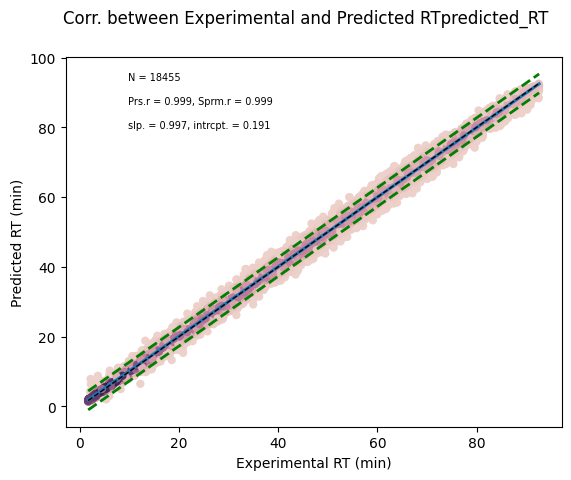

In [12]:
# MQ_pred_filtered: input for SBS
%matplotlib inline
RTmetric = RT_metrics(RT_obs = MQ_pred_filtered['Retention time'], RT_pred = MQ_pred_filtered['predicted_RT'])
print('MAE: ', RTmetric.CalcMAE())
print('Delta RT 95%: ', RTmetric.CalcDeltaRTwidth(95))
print('Pearson Corr: ', RTmetric.CalcPrsCorr())
RTmetric.PlotRTScatter()

<module 'utils.metrics' from '/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utils/metrics.py'>

MAE:  1.9366259873433445
Delta RT 95%:  9.699173821328033
Pearson Corr:  0.9890111830265199
Green line shows deltaRT 95
Data:  tr cal_pred_0.9 , slope =  0.982 , intercept =  0.941 , PearsonR =  0.989 , SpearmanR =  0.989


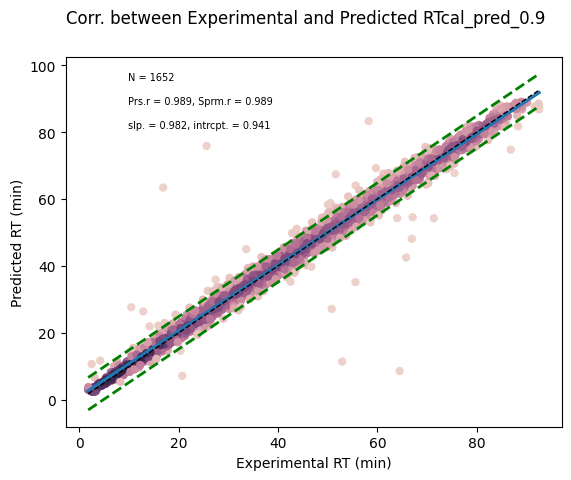

In [12]:
# calibration result
%matplotlib inline
RTmetric = RT_metrics(RT_obs = df_test["tr"], RT_pred = df_test[cal_pred_col])
print('MAE: ', RTmetric.CalcMAE())
print('Delta RT 95%: ', RTmetric.CalcDeltaRTwidth(95))
print('Pearson Corr: ', RTmetric.CalcPrsCorr())
RTmetric.PlotRTScatter()

<module 'utils.metrics' from '/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utils/metrics.py'>

MAE:  1.1608703823630984
Delta RT 95%:  5.829981327397314
Pearson Corr:  0.9946962049224091
Green line shows deltaRT 95
Data:  tr predicted_RT , slope =  0.993 , intercept =  0.286 , PearsonR =  0.995 , SpearmanR =  0.995


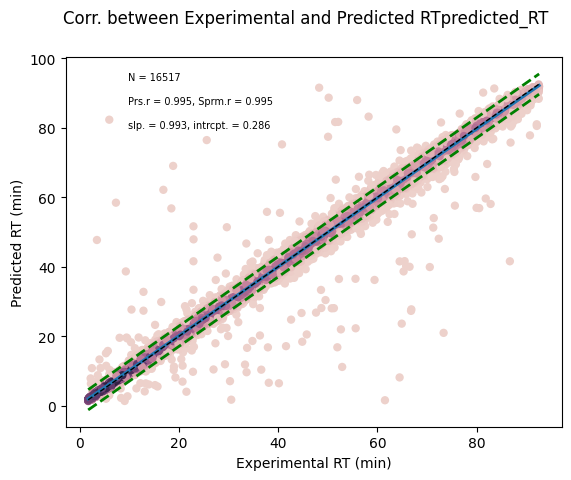

In [16]:
# transfer learning result: all
%matplotlib inline
RTmetric = RT_metrics(RT_obs = df["tr"], RT_pred = df['predicted_RT'])
print('MAE: ', RTmetric.CalcMAE())
print('Delta RT 95%: ', RTmetric.CalcDeltaRTwidth(95))
print('Pearson Corr: ', RTmetric.CalcPrsCorr())
RTmetric.PlotRTScatter()

<module 'utils.metrics' from '/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utils/metrics.py'>

MAE:  1.326964570976793
Delta RT 95%:  6.198070866356555
Pearson Corr:  0.9914001023888452
Green line shows deltaRT 95
Data:  tr trans_pred_0.9 , slope =  0.99 , intercept =  0.499 , PearsonR =  0.991 , SpearmanR =  0.991


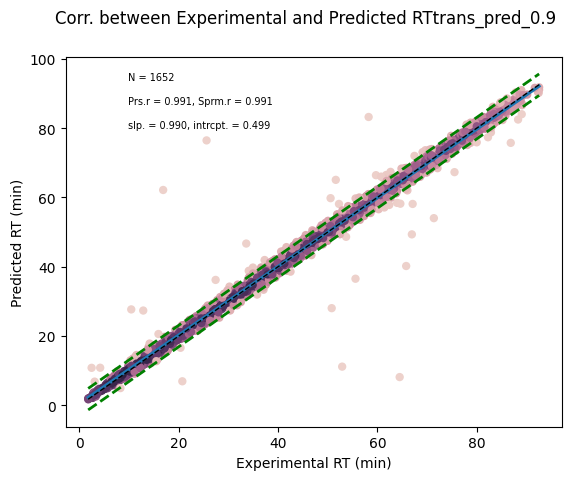

In [13]:
# transfer learning result: test
%matplotlib inline
RTmetric = RT_metrics(RT_obs = df_test["tr"], RT_pred = df_test[trans_pred_col])
print('MAE: ', RTmetric.CalcMAE())
print('Delta RT 95%: ', RTmetric.CalcDeltaRTwidth(95))
print('Pearson Corr: ', RTmetric.CalcPrsCorr())
RTmetric.PlotRTScatter()